In [1]:
data("PlantGrowth")
?PlantGrowth
head(PlantGrowth)

weight,group
<dbl>,<fct>
4.17,ctrl
5.58,ctrl
5.18,ctrl
6.11,ctrl
4.50,ctrl
4.61,ctrl


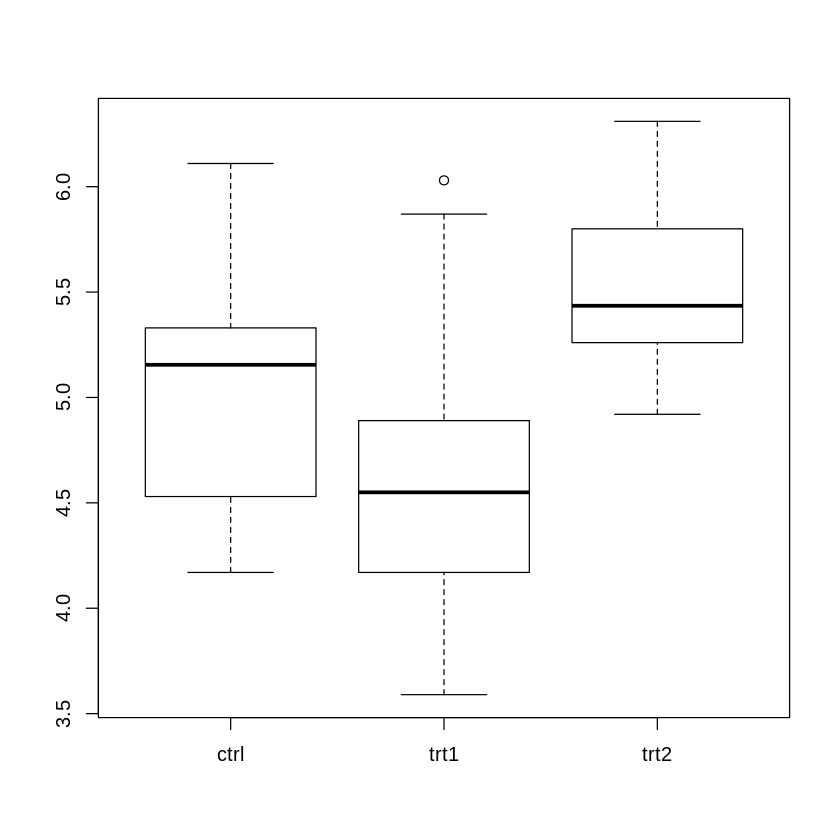

In [2]:
boxplot(weight ~ group, data=PlantGrowth)

In [3]:
lmod = lm(weight ~ group, data=PlantGrowth)
summary(lmod)


Call:
lm(formula = weight ~ group, data = PlantGrowth)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.0710 -0.4180 -0.0060  0.2627  1.3690 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   5.0320     0.1971  25.527   <2e-16 ***
grouptrt1    -0.3710     0.2788  -1.331   0.1944    
grouptrt2     0.4940     0.2788   1.772   0.0877 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6234 on 27 degrees of freedom
Multiple R-squared:  0.2641,	Adjusted R-squared:  0.2096 
F-statistic: 4.846 on 2 and 27 DF,  p-value: 0.01591


In [4]:
anova(lmod)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
group,2,3.76634,1.8831700,4.846088,0.01590996
Residuals,27,10.49209,0.3885959,NA,NA


In [5]:
library("rjags")

Loading required package: coda
Linked to JAGS 4.3.0
Loaded modules: basemod,bugs


In [25]:
mod_string = " model {
    for (i in 1:length(y)) {
        y[i] ~ dnorm(mu[grp[i]], prec)
    }
    
    for (j in 1:3) {
        mu[j] ~ dnorm(0.0, 1.0/1.0e6)
    }

    prec ~ dgamma(5/2.0, 5*1.0/2.0)
    sig = sqrt(1.0 / prec)
} "

set.seed(82)
str(PlantGrowth)
data_jags = list(y=PlantGrowth$weight, grp=as.numeric(PlantGrowth$group))

params = c("mu", "sig")

inits = function() {
    inits = list("mu"=rnorm(3,0.0,100.0), "prec"=rgamma(1,1.0,1.0))
}

mod = jags.model(textConnection(mod_string), data=data_jags, n.chains=3, inits=inits)
update(mod, 1e3)

mod_sim = coda.samples(model=mod, variable.names=params, n.iter=5e3)
mod_csim = as.mcmc(do.call(rbind, mod_sim)) # combined chains

'data.frame':	30 obs. of  2 variables:
 $ weight: num  4.17 5.58 5.18 6.11 4.5 4.61 5.17 4.53 5.33 5.14 ...
 $ group : Factor w/ 3 levels "ctrl","trt1",..: 1 1 1 1 1 1 1 1 1 1 ...
Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 30
   Unobserved stochastic nodes: 4
   Total graph size: 74

Initializing model



Potential scale reduction factors:

      Point est. Upper C.I.
mu[1]          1          1
mu[2]          1          1
mu[3]          1          1
sig            1          1

Multivariate psrf

1

,mu[1],mu[2],mu[3],sig
Lag 0,1.000000000,1.0000000000,1.0000000000,1.000000000
Lag 1,0.006124418,0.0008752776,0.0125359814,0.091704592
Lag 5,0.009374674,0.0021044490,-0.0055847210,0.001900560
Lag 10,-0.003491167,0.0078755677,0.0043794980,-0.001871489
Lag 50,-0.005547719,-0.0062519724,-0.0006503145,0.006836305


mu[1]    mu[2]    mu[3]      sig 
14602.02 15000.00 14792.24 13015.99

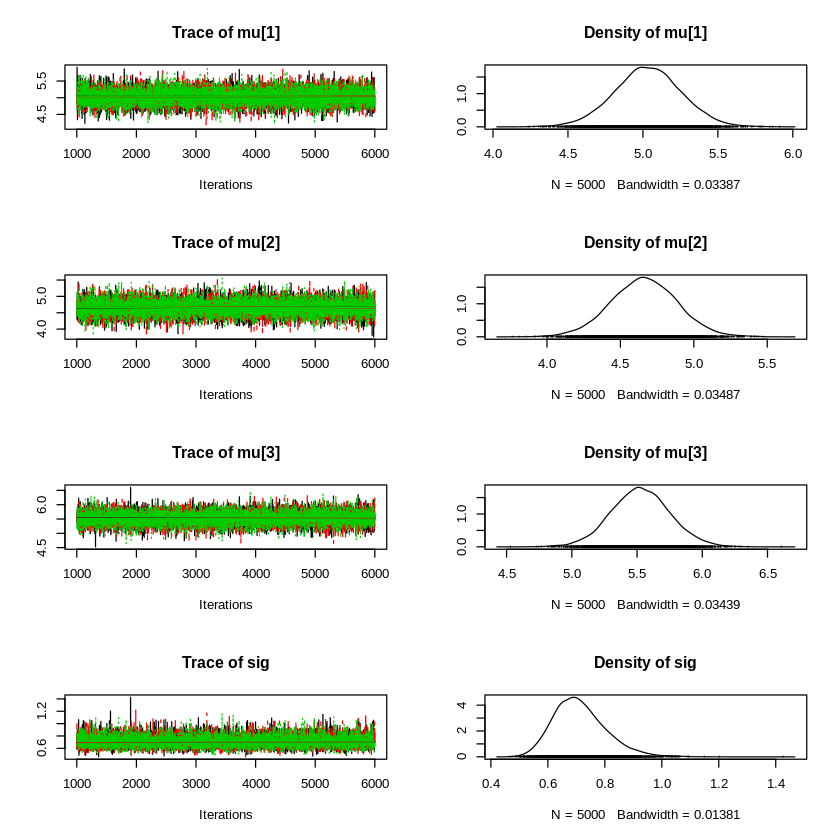

In [26]:
plot(mod_sim)

gelman.diag(mod_sim)
autocorr.diag(mod_sim)
effectiveSize(mod_sim)

In [27]:
(pm_params = colMeans(mod_csim))

mu[1]     mu[2]     mu[3]       sig 
5.0326373 4.6611702 5.5276660 0.7124882

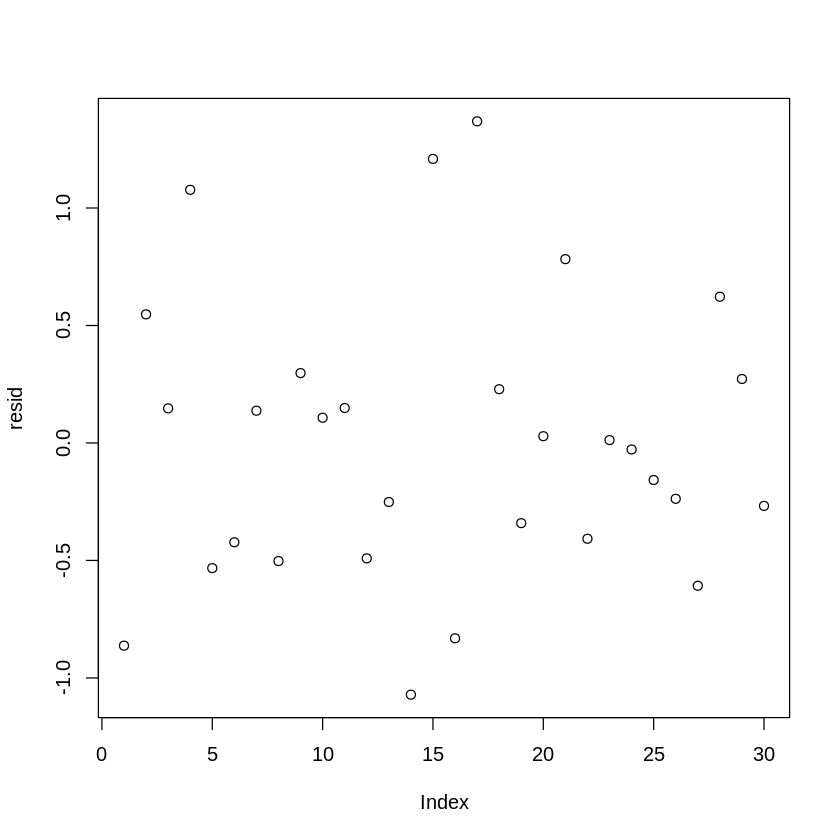

In [28]:
yhat = pm_params[1:3][data_jags$grp]
resid = data_jags$y - yhat
plot(resid)

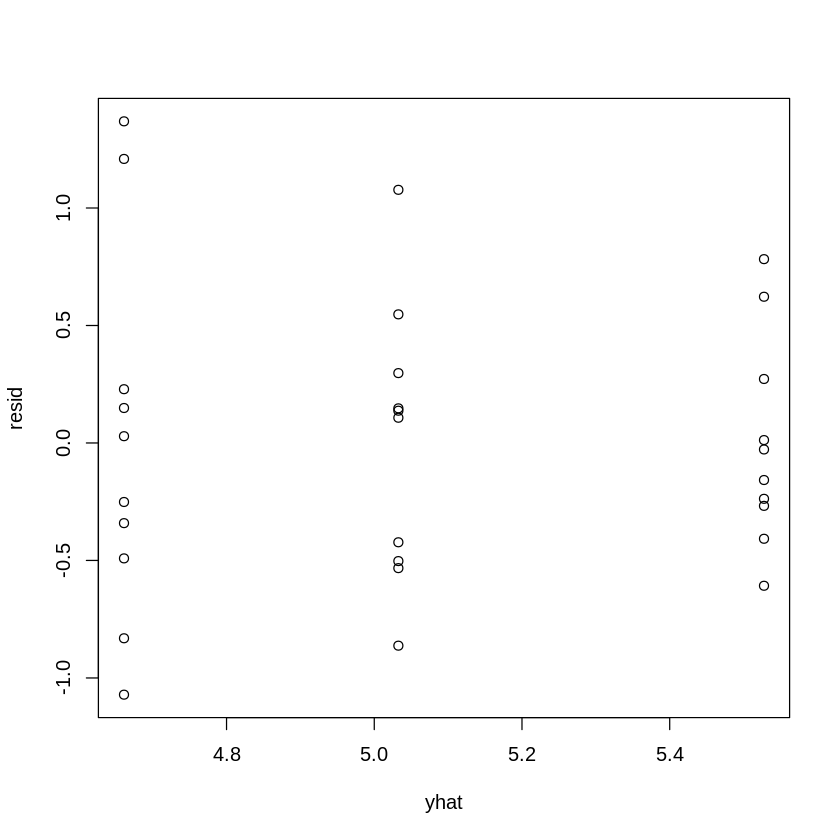

In [29]:
plot(yhat, resid)

In [30]:
summary(mod_sim)


Iterations = 1001:6000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 5000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean      SD  Naive SE Time-series SE
mu[1] 5.0326 0.22412 0.0018299      0.0018553
mu[2] 4.6612 0.22683 0.0018521      0.0018522
mu[3] 5.5277 0.22597 0.0018451      0.0018585
sig   0.7125 0.09264 0.0007564      0.0008124

2. Quantiles for each variable:

       2.5%    25%    50%    75% 97.5%
mu[1] 4.591 4.8855 5.0324 5.1785 5.474
mu[2] 4.211 4.5107 4.6605 4.8123 5.107
mu[3] 5.084 5.3776 5.5247 5.6750 5.979
sig   0.559 0.6471 0.7027 0.7666 0.921


In [31]:
HPDinterval(mod_csim)

,lower,upper
mu[1],4.582409,5.4630527
mu[2],4.229813,5.1238764
mu[3],5.077010,5.9697957
sig,0.545122,0.9021195


In [32]:
mean(mod_csim[,3] > mod_csim[,1])

[1] 0.94

In [33]:
mean(mod_csim[,3] > 1.1*mod_csim[,1])

[1] 0.4885333

In [36]:
mod2_string = " model {
    for (i in 1:length(y)) {
        y[i] ~ dnorm(mu[grp[i]], prec[grp[i]])
    }
    
    for (j in 1:3) {
        mu[j] ~ dnorm(0.0, 1.0/1.0e6)
    }

    for (j in 1:3) {
        prec[j] ~ dgamma(5/2.0, 5*1.0/2.0)
        sig[j] = sqrt(1.0 / prec[j])
    }
} "

set.seed(82)
str(PlantGrowth)
data_jags = list(y=PlantGrowth$weight, grp=as.numeric(PlantGrowth$group))

params = c("mu", "sig")

inits = function() {
    inits = list("mu"=rnorm(3,0.0,100.0), "prec"=rgamma(1,1.0,1.0))
}

mod2 = jags.model(textConnection(mod2_string), data=data_jags, n.chains=3)
update(mod2, 1e3)

mod2_sim = coda.samples(model=mod, variable.names=params, n.iter=5e3)
mod2_csim = as.mcmc(do.call(rbind, mod_sim)) # combined chains

'data.frame':	30 obs. of  2 variables:
 $ weight: num  4.17 5.58 5.18 6.11 4.5 4.61 5.17 4.53 5.33 5.14 ...
 $ group : Factor w/ 3 levels "ctrl","trt1",..: 1 1 1 1 1 1 1 1 1 1 ...
Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 30
   Unobserved stochastic nodes: 6
   Total graph size: 80

Initializing model



In [37]:
summary(mod2_sim)


Iterations = 6001:11000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 5000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean      SD  Naive SE Time-series SE
mu[1] 5.0350 0.22747 0.0018573       0.001862
mu[2] 4.6624 0.22393 0.0018284       0.001822
mu[3] 5.5242 0.22893 0.0018692       0.001908
sig   0.7128 0.09223 0.0007531       0.000813

2. Quantiles for each variable:

        2.5%    25%    50%   75%  97.5%
mu[1] 4.5868 4.8848 5.0354 5.185 5.4793
mu[2] 4.2153 4.5126 4.6650 4.813 5.0962
mu[3] 5.0730 5.3715 5.5255 5.676 5.9709
sig   0.5617 0.6489 0.7023 0.767 0.9217


In [38]:
dic1 = dic.samples(mod, n.iter=1e4)
dic2 = dic.samples(mod2, n.iter=1e4)
dic1-dic2

Difference: -3.935126
Sample standard error: 1.632245

In [39]:
HPDinterval(mod_csim[,3] - mod_csim[,1])

,lower,upper
var1,-0.1196539,1.128769
